## **NLP: Spam-Ham Classifier**

*A Machine Learning Classifier to Classify whether the Message is Spam or Ham using Natural Language Processing(NLP)*

In [71]:
# Import libraries for reading data, exploring and plotting
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
from wordcloud import WordCloud
import string

# Import Machine Learning libraries 
from sklearn import metrics 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB, GaussianNB

# Import NLTK libraries
import nltk 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk import FreqDist
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk import pos_tag, ne_chunk

In [2]:
# Read the CSV file into a pandas DataFrame

data = pd.read_csv('C:/Users/user/Desktop/Python/Main_Projects/NLP/Sentiment_Analysis/SMSSpamCollection', sep='\t', header=None)

In [3]:
# Create a copy of the DataFrame 'data' and assign it to a new variable 'df'

df = data.copy()

In [4]:
# Display the first few rows of the DataFrame to preview its structure

df.head()

,0,1
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


**Rename the column names**

In [7]:
# 'Label' is assigned to the column at index 0, and 'Message' is assigned to the column at index 1.

df.rename(columns={0: 'Label', 1: 'Message'}, inplace=True)

#### **Exploratory Data Analysis**

In [8]:
df.head()

,Label,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [9]:
# Display concise summary information about the DataFrame 'df', including column names, data types, non-null counts, and memory usage.

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Label    5572 non-null   object
 1   Message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [10]:
# Generate descriptive statistics of the DataFrame 'df'.

df.describe()

,Label,Message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


**Insights**
- Label Distribution: *The dataset contains a total of 5,572 entries. Among these, the majority (4,825) are labeled as 'ham', indicating non-spam messages, while the remaining 747 entries are labeled as 'spam'. This suggests an imbalance in the dataset, with 'ham' messages being significantly more prevalent.*

- Message Variability: *There are 5,169 unique messages in the dataset, indicating wide variety of text content. However, some messages are repeated, with the most frequent message being - "Sorry, I'll call later", occuring 30 times.*

- Task Objective: *The task of sentiment analysis or spam detection involves predicting the label ('ham' or 'spam') for each message based on its content.*

In [11]:
# Group the DataFrame 'df' by the 'Label' column and generate descriptive statistics for each group.

df.groupby('Label').describe()

Message                                                               
        count unique                                                top freq
Label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

- *Out of the 5,572 messages in the dataset, 4,825 are categorized as 'ham' (non-spam), with 4,516 unique messages.* 

- *Conversely, there are 747 spam messages, out of which 653 are unique.*

In [12]:
# Counting Message Occurrences and Calculating Dense Ranks for Top 5 Messages

message_coutns = df['Message'].value_counts().reset_index().sort_values(by='count', ascending=False)

# Calculating the Dense ranks for the top 5 messages
message_coutns['Rank'] = message_coutns['count'].rank(method='dense', ascending=False).astype('int')

message_coutns[message_coutns['Rank'] <= 5]

,Message,count,Rank
0,"Sorry, I'll call later",30,1
1,I cant pick the phone right now. Pls send a me...,12,2
2,Ok...,10,3
7,"Wen ur lovable bcums angry wid u, dnt take it ...",4,4
10,Ok,4,4
...,...,...,...
31,"Sorry, I can't help you on this.",3,5
28,Ok.ok ok..then..whats ur todays plan,3,5
27,"She said,'' do u mind if I go into the bedroom...",3,5
29,Wife.how she knew the time of murder exactly,3,5


**Let's create a new feature to capture the length of text messages.**

In [13]:
df['Txt_length'] = df['Message'].apply(len)
df.head()

,Label,Message,Txt_length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


In [14]:
# Function to count the total number of punctuation marks in a text

def find_punct(text):

    count = 0
    for char in text:
        if char in string.punctuation:
            count += 1
    
    return count
    
df['Total_Punct'] = df['Message'].apply(lambda x: find_punct(x))

In [15]:
df.head()

,Label,Message,Txt_length,Total_Punct
0,ham,"Go until jurong point, crazy.. Available only ...",111,9
1,ham,Ok lar... Joking wif u oni...,29,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,6
3,ham,U dun say so early hor... U c already then say...,49,6
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,2


#### **Analyzing the difference between Spam and Ham messages**

In [16]:
# Extract spam messages from the DataFrame
spam_messages = df[df['Label'] == 'spam']

# Extract ham messages from the DataFrame
ham_messages = df[df['Label'] == 'ham']

In [17]:
print(f"Spam Message Punctuation Mean: {spam_messages['Total_Punct'].mean()}")

print(f"Ham Message Punctuation Mean: {ham_messages['Total_Punct'].mean()}")

Spam Message Punctuation Mean: 5.712182061579652
Ham Message Punctuation Mean: 3.9398963730569947


In [18]:
print(f"Spam Message Length Mean: {spam_messages['Txt_length'].mean()}")

print(f"Ham Message Length Mean: {ham_messages['Txt_length'].mean()}")

Spam Message Length Mean: 138.6706827309237
Ham Message Length Mean: 71.48248704663213


**Punctuation Usage:** On average, Spam messages exhibit a higher punctuation count compared to ham messages, with a mean punctuation count of approximately **5.71** for spam messages and **3.94** for ham messages.

*This suggest that spam messages tend to contain more punctuation marks, possibly to grab attention or create urgency*

**Message Length:** Additionalyy, Spam messages are longer on average compared to ham messages, with a mean length of approximately **138** characters for spam messages and **71** characters for ham messages.

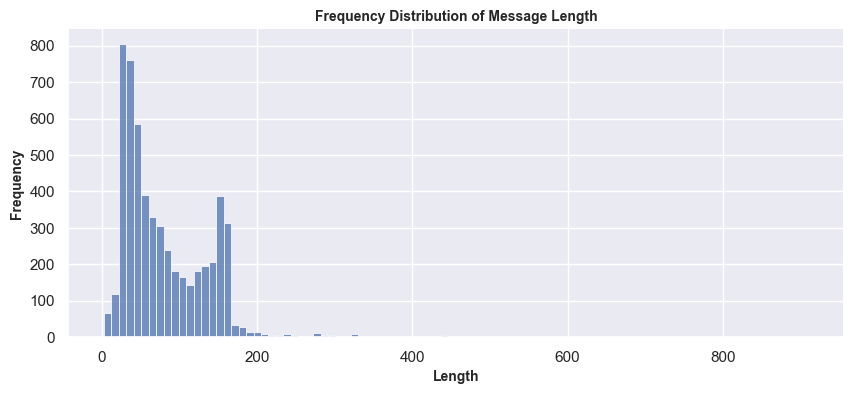

In [18]:
# Visualizing the Frequency Distribution of message length

sns.set_theme(style='darkgrid')
plt.figure(figsize=(10, 4))
sns.histplot(x=df['Txt_length'])

plt.title('Frequency Distribution of Message Length', fontdict={'weight': 'bold', 'fontsize': 10})
plt.xlabel('Length', fontdict={'weight': 'bold', 'fontsize': 10})
plt.ylabel('Frequency', fontdict={'weight': 'bold', 'fontsize': 10})

sns.despine()
plt.show()

*Many messages have a length of less than 200 characters. However, it's worth noting that the x-axis extends to around 1,000 indicating the presence of some exceptionally long messages.*

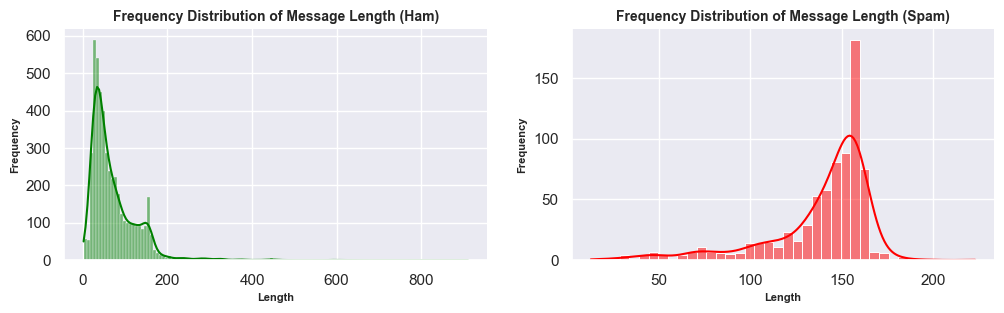

In [19]:
# Frequency Distribution of message length for Ham and Spam 

# Set up the plot
sns.set_theme(style='darkgrid')
plt.figure(figsize=(12, 3))

# Plot histogram for Ham messages
plt.subplot(1, 2, 1)
sns.histplot(x=ham_messages['Txt_length'], color='green', kde=True)
plt.title('Frequency Distribution of Message Length (Ham)', fontdict={'weight': 'bold', 'fontsize': 10})
plt.xlabel('Length', fontdict={'weight': 'bold', 'fontsize': 8})
plt.ylabel('Frequency', fontdict={'weight': 'bold', 'fontsize': 8})

# Plot histogram for Spam messages
plt.subplot(1, 2, 2)
sns.histplot(x=spam_messages['Txt_length'], color='red', kde=True)
plt.title('Frequency Distribution of Message Length (Spam)', fontdict={'weight': 'bold', 'fontsize': 10})
plt.xlabel('Length', fontdict={'weight': 'bold', 'fontsize': 8})
plt.ylabel('Frequency', fontdict={'weight': 'bold', 'fontsize': 8})

sns.despine()
plt.show()

*It appears that there's a trend where spam messages tend to be longer than ham messages.*

### **Text Pre-Processing**

**1. Tokenization**

Tokenizing separates text into units such as sentences or words. It gives structure to previously unstructured text. eg: Plata o Plomo-> ‘Plata’,’o’,’Plomo’.

In [20]:

df['MSG_Tokenized'] = df['Message'].apply(lambda x: word_tokenize(x))

df.head()

,Label,Message,Txt_length,Total_Punct,MSG_Tokenized
0,ham,"Go until jurong point, crazy.. Available only ...",111,9,"[Go, until, jurong, point, ,, crazy, .., Avail..."
1,ham,Ok lar... Joking wif u oni...,29,6,"[Ok, lar, ..., Joking, wif, u, oni, ...]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,6,"[Free, entry, in, 2, a, wkly, comp, to, win, F..."
3,ham,U dun say so early hor... U c already then say...,49,6,"[U, dun, say, so, early, hor, ..., U, c, alrea..."
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,2,"[Nah, I, do, n't, think, he, goes, to, usf, ,,..."


**2. Remove Punctuation***

Punctuation can provide grammatical context to a sentence which supports our understanding. However for our vectorizer which counts the number of words and not the context, it does not add value, So we remove all special characteres.

In [35]:
# Function to remove puntuation

def remove_punct(text):
    cld_txt = "".join(char for char in text if char not in string.punctuation)
    return cld_txt

df['MSG_nopunct'] = df['MSG_Tokenized'].apply(lambda words: [remove_punct(word) for word in words])

df.head()

,Label,Message,Txt_length,Total_Punct,MSG_Tokenized,MSG_nopunct
0,ham,"Go until jurong point, crazy.. Available only ...",111,9,"[Go, until, jurong, point, ,, crazy, .., Avail...","[Go, until, jurong, point, , crazy, , Availabl..."
1,ham,Ok lar... Joking wif u oni...,29,6,"[Ok, lar, ..., Joking, wif, u, oni, ...]","[Ok, lar, , Joking, wif, u, oni, ]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,6,"[Free, entry, in, 2, a, wkly, comp, to, win, F...","[Free, entry, in, 2, a, wkly, comp, to, win, F..."
3,ham,U dun say so early hor... U c already then say...,49,6,"[U, dun, say, so, early, hor, ..., U, c, alrea...","[U, dun, say, so, early, hor, , U, c, already,..."
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,2,"[Nah, I, do, n't, think, he, goes, to, usf, ,,...","[Nah, I, do, nt, think, he, goes, to, usf, , h..."


In [41]:
# Function to remove non-alphabetic characters
def remove_non_alpha(text):
    cleaned_text = "".join(char for char in text if char.isalpha())
    return cleaned_text

# Apply the function to each tokenized message and remove non-alphabetic characters
df['MSG_nopunct'] = df['MSG_nopunct'].apply(lambda words: [remove_non_alpha(word) for word in words])

**3. Remove Stopwords**

Stopwords are common words that will likely appear in any text. They don’t tell us much about our data so we remove them. eg: silver or lead is fine for me-> silver, lead, fine.

In [43]:
# Function to remove stopwords

def remove_stopwords(text):

    from nltk.corpus import stopwords
    stopwords = set(stopwords.words('english'))

    text = [word for word in text if word not in stopwords]
    return text

df['MSG_nonstop'] = df['MSG_nopunct'].apply(lambda x: remove_stopwords(x))

df.head()

,Label,Message,Txt_length,Total_Punct,MSG_Tokenized,MSG_nopunct,MSG_nonstop
0,ham,"Go until jurong point, crazy.. Available only ...",111,9,"[Go, until, jurong, point, ,, crazy, .., Avail...","[Go, until, jurong, point, , crazy, , Availabl...","[Go, jurong, point, , crazy, , Available, bugi..."
1,ham,Ok lar... Joking wif u oni...,29,6,"[Ok, lar, ..., Joking, wif, u, oni, ...]","[Ok, lar, , Joking, wif, u, oni, ]","[Ok, lar, , Joking, wif, u, oni, ]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,6,"[Free, entry, in, 2, a, wkly, comp, to, win, F...","[Free, entry, in, , a, wkly, comp, to, win, FA...","[Free, entry, , wkly, comp, win, FA, Cup, fina..."
3,ham,U dun say so early hor... U c already then say...,49,6,"[U, dun, say, so, early, hor, ..., U, c, alrea...","[U, dun, say, so, early, hor, , U, c, already,...","[U, dun, say, early, hor, , U, c, already, say, ]"
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,2,"[Nah, I, do, n't, think, he, goes, to, usf, ,,...","[Nah, I, do, nt, think, he, goes, to, usf, , h...","[Nah, I, nt, think, goes, usf, , lives, around..."


In [44]:
# Remove empty strings from the list of tokens

def remove_empty_string(text):

    text = [token for token in text if token]
    return text

df['MSG_nonstop'] = df['MSG_nonstop'].apply(lambda x: remove_empty_string(x))

In [45]:
df.head()

,Label,Message,Txt_length,Total_Punct,MSG_Tokenized,MSG_nopunct,MSG_nonstop
0,ham,"Go until jurong point, crazy.. Available only ...",111,9,"[Go, until, jurong, point, ,, crazy, .., Avail...","[Go, until, jurong, point, , crazy, , Availabl...","[Go, jurong, point, crazy, Available, bugis, n..."
1,ham,Ok lar... Joking wif u oni...,29,6,"[Ok, lar, ..., Joking, wif, u, oni, ...]","[Ok, lar, , Joking, wif, u, oni, ]","[Ok, lar, Joking, wif, u, oni]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,6,"[Free, entry, in, 2, a, wkly, comp, to, win, F...","[Free, entry, in, , a, wkly, comp, to, win, FA...","[Free, entry, wkly, comp, win, FA, Cup, final,..."
3,ham,U dun say so early hor... U c already then say...,49,6,"[U, dun, say, so, early, hor, ..., U, c, alrea...","[U, dun, say, so, early, hor, , U, c, already,...","[U, dun, say, early, hor, U, c, already, say]"
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,2,"[Nah, I, do, n't, think, he, goes, to, usf, ,,...","[Nah, I, do, nt, think, he, goes, to, usf, , h...","[Nah, I, nt, think, goes, usf, lives, around, ..."


**Let's delve deeper into the data by analyzing ham and spam messages separately. We'll create separate DataFrames for each label group to generate WordClouds.**

In [46]:
# Extract all the ham and spam emails

df_cld = df.copy()
df_cld['MSG_nonstop'] = df_cld['MSG_nonstop'].apply(lambda x: ' '.join(x))

ham_msg = df_cld[df_cld['Label'] == 'ham']['MSG_nonstop']
spam_msg = df_cld[df_cld['Label'] == 'spam']['MSG_nonstop']

# Combine ham messages into a single string
ham_msg_txt = ' '.join(ham_msg)

# Combine spam messages into a single string
spam_msg_txt = ' '.join(spam_msg)

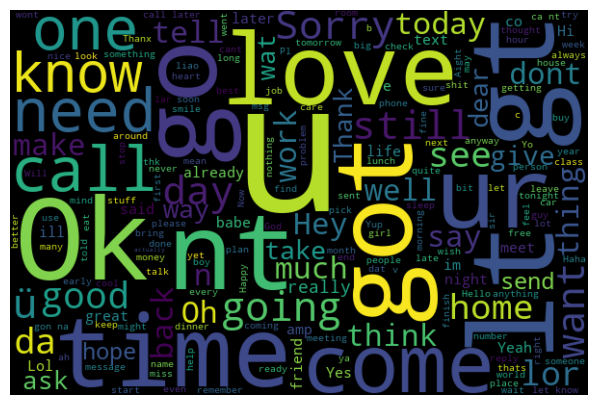

In [47]:
# Wordcloud for Ham Message
ham_msg_cloud = WordCloud(width=600, height=400, background_color='black').generate(ham_msg_txt)
plt.figure(figsize=(10, 5))
plt.imshow(ham_msg_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

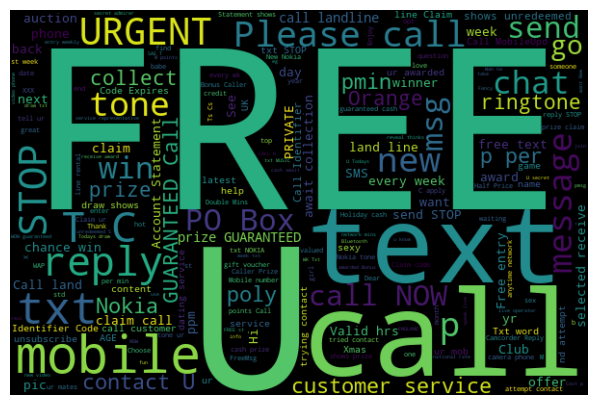

In [48]:
# Wordcloud of Spam Message
spam_msg_cloud = WordCloud(width=600, height=400, background_color='black').generate(spam_msg_txt)
plt.figure(figsize=(10, 5))
plt.imshow(spam_msg_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Most frequently used words in 'Ham' messages are ['got', 'love', 'go', 'call', 'ok', 'time', 'come', 'know', 'need', 'going', 'think']

Most frequently used words in 'Spam' messages are ['free', 'call', 'reply', 'urgent', 'win', 'prize', 'claim', 'Guaranteed', 'please call', 'call now']

In [49]:
# Function to convert words to lowercase
def lower_case(text):

    text = [word.lower() for word in text]
    return text

# Apply the lowercase conversion function to each entry in the 'MSG_nonstop' column

df['MSG_nonstop'] = df['MSG_nonstop'].apply(lambda x: lower_case(x))

#### **Data Normalization: Stemming**

In [50]:
# Function to perform stemming

def stemming(text):

    stemmer = PorterStemmer()

    text = [stemmer.stem(word) for word in text]
    return text 

# Apply stemming to each entry in the 'MSG_nonstop' column

df['MSG_Stem'] = df['MSG_nonstop'].apply(lambda x: stemming(x))

df.head()

,Label,Message,Txt_length,Total_Punct,MSG_Tokenized,MSG_nopunct,MSG_nonstop,MSG_Stem
0,ham,"Go until jurong point, crazy.. Available only ...",111,9,"[Go, until, jurong, point, ,, crazy, .., Avail...","[Go, until, jurong, point, , crazy, , Availabl...","[go, jurong, point, crazy, available, bugis, n...","[go, jurong, point, crazi, avail, bugi, n, gre..."
1,ham,Ok lar... Joking wif u oni...,29,6,"[Ok, lar, ..., Joking, wif, u, oni, ...]","[Ok, lar, , Joking, wif, u, oni, ]","[ok, lar, joking, wif, u, oni]","[ok, lar, joke, wif, u, oni]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,6,"[Free, entry, in, 2, a, wkly, comp, to, win, F...","[Free, entry, in, , a, wkly, comp, to, win, FA...","[free, entry, wkly, comp, win, fa, cup, final,...","[free, entri, wkli, comp, win, fa, cup, final,..."
3,ham,U dun say so early hor... U c already then say...,49,6,"[U, dun, say, so, early, hor, ..., U, c, alrea...","[U, dun, say, so, early, hor, , U, c, already,...","[u, dun, say, early, hor, u, c, already, say]","[u, dun, say, earli, hor, u, c, alreadi, say]"
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,2,"[Nah, I, do, n't, think, he, goes, to, usf, ,,...","[Nah, I, do, nt, think, he, goes, to, usf, , h...","[nah, i, nt, think, goes, usf, lives, around, ...","[nah, i, nt, think, goe, usf, live, around, th..."


#### **Data Normalization: Lemmatization**

In [51]:
# Function to perform lemmatization
def lemmatizing(text):

    lemmatizer = WordNetLemmatizer()

    text = [lemmatizer.lemmatize(word) for word in text]
    return text 

# Apply lemmatization to each entry in the 'MSG_nonstop' column

df['MSG_Lemmt'] = df['MSG_nonstop'].apply(lambda x: lemmatizing(x))

df.head()

,Label,Message,Txt_length,Total_Punct,MSG_Tokenized,MSG_nopunct,MSG_nonstop,MSG_Stem,MSG_Lemmt
0,ham,"Go until jurong point, crazy.. Available only ...",111,9,"[Go, until, jurong, point, ,, crazy, .., Avail...","[Go, until, jurong, point, , crazy, , Availabl...","[go, jurong, point, crazy, available, bugis, n...","[go, jurong, point, crazi, avail, bugi, n, gre...","[go, jurong, point, crazy, available, bugis, n..."
1,ham,Ok lar... Joking wif u oni...,29,6,"[Ok, lar, ..., Joking, wif, u, oni, ...]","[Ok, lar, , Joking, wif, u, oni, ]","[ok, lar, joking, wif, u, oni]","[ok, lar, joke, wif, u, oni]","[ok, lar, joking, wif, u, oni]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,6,"[Free, entry, in, 2, a, wkly, comp, to, win, F...","[Free, entry, in, , a, wkly, comp, to, win, FA...","[free, entry, wkly, comp, win, fa, cup, final,...","[free, entri, wkli, comp, win, fa, cup, final,...","[free, entry, wkly, comp, win, fa, cup, final,..."
3,ham,U dun say so early hor... U c already then say...,49,6,"[U, dun, say, so, early, hor, ..., U, c, alrea...","[U, dun, say, so, early, hor, , U, c, already,...","[u, dun, say, early, hor, u, c, already, say]","[u, dun, say, earli, hor, u, c, alreadi, say]","[u, dun, say, early, hor, u, c, already, say]"
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,2,"[Nah, I, do, n't, think, he, goes, to, usf, ,,...","[Nah, I, do, nt, think, he, goes, to, usf, , h...","[nah, i, nt, think, goes, usf, lives, around, ...","[nah, i, nt, think, goe, usf, live, around, th...","[nah, i, nt, think, go, usf, life, around, tho..."


#### **Visualizing the Distribution of Target Variable - Spam OR Ham**

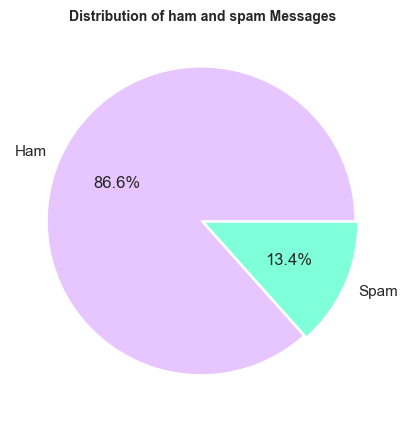

In [52]:
# Visualizing the Distribution of Target Variable - Spam OR Ham

plt.figure(figsize=(5, 5))
plt.pie(df['Label'].value_counts(), labels=['Ham', 'Spam'], colors=['#e7c6ff', '#80ffdb'], autopct='%1.1f%%', explode=(0.01, 0.01))
plt.title('Distribution of ham and spam Messages', fontdict={'weight': 'bold', 'fontsize': 10})

plt.show()

*Now, let's further explore the imbalanced data. The pie chart clearly illustrates the class distribution imbalance, with the majority being ham messages (86%) and a minority being spam messages (13%).*

### **Vectorizing Data**

*Vectorizing is the process of converting textual data into numerical representations, typically in the form of feature vectors. This encoding enables machine learning algorithms to comprehend and process the data effectively. By assigning numeric values to words or tokens, vectorization facilitates the transformation of text-based information into a format that can be utilized for training and prediction tasks within machine learning models.*

In [53]:
# Create a new DataFrame containing only the 'MSG_Lemmt' and 'Label' columns

ndf = df[['MSG_Lemmt', 'Label']]

In [54]:
# Concatenate the list of lemmatized words into a single string for each row

ndf['MSG_Lemmt'] = [' '.join(word) for word in ndf['MSG_Lemmt']]

C:\Users\user\AppData\Local\Temp\ipykernel_2944\553092032.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ndf['MSG_Lemmt'] = [' '.join(word) for word in ndf['MSG_Lemmt']]


In [55]:
ndf.head()

,MSG_Lemmt,Label
0,go jurong point crazy available bugis n great ...,ham
1,ok lar joking wif u oni,ham
2,free entry wkly comp win fa cup final tkts st ...,spam
3,u dun say early hor u c already say,ham
4,nah i nt think go usf life around though,ham


**Splitting the Data into X & Y**

In [129]:
X = ndf['MSG_Lemmt']
Y = ndf['Label']

In [130]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the training labels
Y = label_encoder.fit_transform(Y)

**Vectorizing Data: TF-IDF**

In [131]:
# Initialize the TF-IDF vectorizer with a maximum of 1500 features
tfidf_vec = TfidfVectorizer(max_features=1500)

# Transform the input data X using the TF-IDF vectorizer and convert the result to an array
tf_xvec = tfidf_vec.fit_transform(X).toarray()

tf_xvec

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

**Splitting the Data into Training and Testing**

In [77]:
xtrain, xtest, ytrain, ytest = train_test_split(tf_xvec, Y, test_size=0.2, random_state=4)

print(f'The Shape of Xtrain: {xtrain.shape}')
print(f'The Shape of Xtest: {xtest.shape}')
print(f'The Shape of Ytrain: {ytrain.shape}')
print(f'The Shape of Ytest: {ytest.shape}')

The Shape of Xtrain: (4457, 1500)
The Shape of Xtest: (1115, 1500)
The Shape of Ytrain: (4457,)
The Shape of Ytest: (1115,)


### **Model Building and Model Architecture**

**LogisticRegression Classifier**

In [78]:
# Initialize the Logistic Regression classifier
logistic_model = LogisticRegression()

# Train the classifier on the training data
logistic_model.fit(xtrain, ytrain)

# Prediction on the train and test data
train_pred = logistic_model.predict(xtrain)
test_pred = logistic_model.predict(xtest)

# Evaluate the accuracy of the classifier
train_accuracy = metrics.accuracy_score(ytrain, train_pred)
test_accuracy = metrics.accuracy_score(ytest, test_pred)

print(f"Training Accuracy: {np.round(train_accuracy, 3)*100}\n")
print(f"Testing Accuracy: {np.round(test_accuracy, 3)*100}\n")

# Print classification report for Training
print("Classification Report For Training:")
print(f"{metrics.classification_report(ytrain, train_pred)}\n")

# Print classification report for Testing
print("Classification Report For Testing:")
print(metrics.classification_report(ytest, test_pred))

Training Accuracy: 97.5

Testing Accuracy: 95.89999999999999

Classification Report For Training:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      3878
           1       0.99      0.82      0.90       579

    accuracy                           0.98      4457
   macro avg       0.98      0.91      0.94      4457
weighted avg       0.98      0.98      0.97      4457


Classification Report For Testing:
              precision    recall  f1-score   support

           0       0.95      1.00      0.98       947
           1       1.00      0.73      0.84       168

    accuracy                           0.96      1115
   macro avg       0.98      0.86      0.91      1115
weighted avg       0.96      0.96      0.96      1115



**Multinomial Naive Bayes.**

In [79]:
# Initialize the Naive Bayes classifier
NB_model = MultinomialNB()

# Train the classifier on the training data
NB_model.fit(xtrain, ytrain)

# Prediction on the train and test data
train_pred = NB_model.predict(xtrain)
test_pred = NB_model.predict(xtest)

# Evaluate the accuracy of the classifier
train_accuracy = metrics.accuracy_score(ytrain, train_pred)
test_accuracy = metrics.accuracy_score(ytest, test_pred)

print(f"Training Accuracy: {np.round(train_accuracy, 3)*100}\n")
print(f"Testing Accuracy: {np.round(test_accuracy, 3)*100}\n")

# Print classification report for Training
print("Classification Report For Training:")
print(f"{metrics.classification_report(ytrain, train_pred)}\n")

# Print classification report for Testing
print("Classification Report For Testing:")
print(metrics.classification_report(ytest, test_pred))

Training Accuracy: 98.1

Testing Accuracy: 96.6

Classification Report For Training:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3878
           1       0.99      0.86      0.92       579

    accuracy                           0.98      4457
   macro avg       0.99      0.93      0.96      4457
weighted avg       0.98      0.98      0.98      4457


Classification Report For Testing:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       947
           1       0.99      0.79      0.87       168

    accuracy                           0.97      1115
   macro avg       0.97      0.89      0.93      1115
weighted avg       0.97      0.97      0.96      1115



**XGBClassifier**

In [80]:
# Initialize the Naive Bayes classifier
XGB_model = XGBClassifier()

# Define hyperparameter grid for Grid Search
params = {
    'max_depth': [2, 5, 10],
    'n_estimators': [300, 500]
}

# Create a GridSearchCV object with the XGBoost model 
grid_search_xgb = GridSearchCV(XGB_model, param_grid=params)

# Train the classifier on the training data
grid_search_xgb.fit(xtrain, ytrain)

best_xgb_model = grid_search_xgb.best_estimator_

# Prediction on the train and test data
x_pred_encoded = best_xgb_model.predict(xtrain)
Y_pred_encoded = best_xgb_model.predict(xtest)

# Evaluate the accuracy of the classifier
train_accuracy = metrics.accuracy_score(ytrain, x_pred_encoded)
test_accuracy = metrics.accuracy_score(ytest, Y_pred_encoded)

print(f"Training Accuracy: {np.round(train_accuracy, 3)*100}\n")
print(f"Testing Accuracy: {np.round(test_accuracy, 3)*100}\n")

# Print classification report for Training
print("Classification Report For Training:")
print(f"{metrics.classification_report(ytrain, x_pred_encoded)}\n")

# Print classification report for Testing
print("Classification Report For Testing:")
print(metrics.classification_report(ytest, Y_pred_encoded))


Training Accuracy: 98.8

Testing Accuracy: 97.5

Classification Report For Training:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3878
           1       1.00      0.91      0.95       579

    accuracy                           0.99      4457
   macro avg       0.99      0.96      0.97      4457
weighted avg       0.99      0.99      0.99      4457


Classification Report For Testing:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       947
           1       0.97      0.86      0.91       168

    accuracy                           0.97      1115
   macro avg       0.97      0.93      0.95      1115
weighted avg       0.97      0.97      0.97      1115



**RandomForest Classifier**

In [88]:
# # Initialize the Naive Bayes classifier
RF_model = RandomForestClassifier()

# Define hyperparameter grid for Grid Search
params = {
    'n_estimators': [250, 500],
    'max_depth': [None, 10, 20],
}

# Create a GridSearchCV object with the Random Forest model and parameters
grid_search_rf = GridSearchCV(RF_model, param_grid=params)

# Train the classifier on the training data
grid_search_rf.fit(xtrain, ytrain)

# Get the best Random Forest model
best_rf_model = grid_search_rf.best_estimator_

# Predict the labels for the train and test data
train_pred = best_rf_model.predict(xtrain)
test_pred = best_rf_model.predict(xtest)

# Evaluate the accuracy of the classifier
train_accuracy = metrics.accuracy_score(ytrain, train_pred)
test_accuracy = metrics.accuracy_score(ytest, test_pred)

print(f"Training Accuracy: {np.round(train_accuracy, 3)*100}\n")
print(f"Testing Accuracy: {np.round(test_accuracy, 3)*100}\n")

# Print classification report for Training
print("Classification Report For Training:")
print(f"{metrics.classification_report(ytrain, train_pred)}\n")

# Print classification report for Testing
print("Classification Report For Testing:")
print(metrics.classification_report(ytest, test_pred))


Training Accuracy: 99.9

Testing Accuracy: 98.2

Classification Report For Training:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3878
           1       1.00      0.99      1.00       579

    accuracy                           1.00      4457
   macro avg       1.00      1.00      1.00      4457
weighted avg       1.00      1.00      1.00      4457


Classification Report For Testing:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       947
           1       1.00      0.88      0.94       168

    accuracy                           0.98      1115
   macro avg       0.99      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115



**Conclusion**

* **The Random Forest classifier** demonstrates superior performance, achieving a high training accuracy of **99.9%** and a commendable testing accuracy of **98.2%**. Furthermore, its precision, recall, and F1-scores for both classes on both the training and testing datasets are consistently high, indicating robust performance across the board. Therefore, based on these evaluation metrics, we can confidently conclude that the Random Forest classifier outperforms other models and is the best choice for this classification task.*

**Confusion Matrix**

Confusion Matrix for Training and Testing Data : 


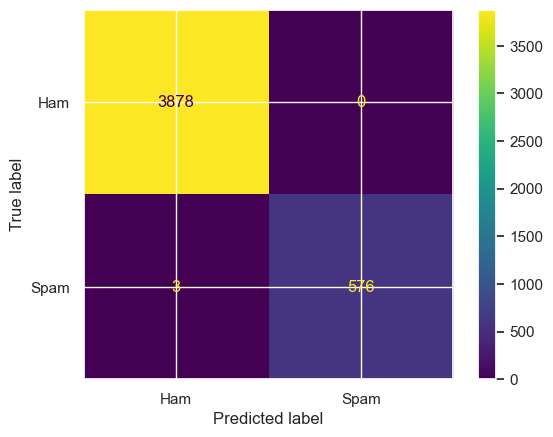

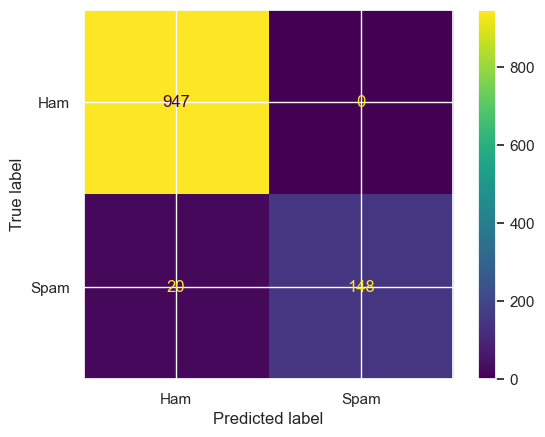

In [95]:
cm_train_rf = metrics.confusion_matrix(ytrain, train_pred)
cm_test_rf = metrics.confusion_matrix(ytest, test_pred)

print('Confusion Matrix for Training and Testing Data : ')
cm_train_ds = metrics.ConfusionMatrixDisplay(confusion_matrix=cm_train_rf, display_labels=['Ham', 'Spam'])

cm_test_ds = metrics.ConfusionMatrixDisplay(confusion_matrix=cm_test_rf, display_labels=['Ham', 'Spam'])

cm_train_ds.plot()
cm_test_ds.plot()
plt.show()

### **Saving and Testing the Model**

In [ ]:
import pickle

# Save TF-IDF vectorizer to a file
with open('TF_IDF_vec', 'wb') as file:
    pickle.dump(tfidf_vec, file)

# Save the Spam Detection Model (Random Forest classifier) to a file
with open('Spam_Detection_Model', 'wb') as file1:
    pickle.dump(best_rf_model, file1)

**Testing**

In [134]:
def transform_text(text):

    from nltk.corpus import stopwords

    text = word_tokenize(text)

    # # Remove punctuations
    text = [char for char in text if char not in string.punctuation]

    # Remove non-alphabetic characters
    text = [char for char in text if char.isalpha()]

    # Remove stopwords
    stopwords = set(stopwords.words('english'))
    text = [word for word in text if word not in stopwords]

    # Convert the words to lowercase
    text = [word.lower() for word in text if word]

    # Apply Lemmatization
    lemmatizer = WordNetLemmatizer()
    text = [lemmatizer.lemmatize(word) for word in text]

    # Convert the list of lemmatized words into a single string 
    text = ' '.join(text)
    
    return text

In [169]:
def Predict(Message):

    # Load TF-IDF vectorizer and Spam Detection Model 
    with open('TF_IDF_vec', 'rb') as f, open('Spam_Detection_Model', 'rb') as f1:
        tfidf = pickle.load(f)
        model = pickle.load(f1)

    # Call the text transformer function
    transformed_message = transform_text(Message)

    # Vectorize the text
    tf_vec_msg = tfidf.transform([transformed_message])

    # Make the prediction
    result = model.predict(tf_vec_msg)[0]

    # display the result
    if result == 1:
        print('The Message is Spam')
    else:
        print('The Message is Ham')

# Example message to predict
Message = 'Congratulations you have won 200 lakh prize'

# Call the predict function with the example message
Predict(Message)

The Message is Spam
